In [2]:
import numpy as np
import pandas as pd
import os, warnings
warnings.filterwarnings("ignore")

In [3]:
# ===============================================================
# 0. CREATE OUTPUT FOLDERS
# ===============================================================
os.makedirs("data", exist_ok=True)
os.makedirs("outputs/regression_plots", exist_ok=True)
os.makedirs("outputs/classification_plots", exist_ok=True)
os.makedirs("outputs/clustering_plots", exist_ok=True)
os.makedirs("outputs/metrics", exist_ok=True)


In [4]:
# ===============================================================
# 1. LOAD RAW E-COMMERCE DATA (download manually into data/)
# ===============================================================
try:
    raw = pd.read_csv("data.csv", encoding="ISO-8859-1")
except:
    raw = pd.read_excel("data/ecommerce_raw.xlsx")

data = raw.copy()
data.columns = [c.strip() for c in data.columns]
data = data.dropna(subset=["CustomerID"])
data = data[data["Quantity"] > 0]
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"] 

In [5]:
# ===============================================================
# 2. CREATE transactions.csv & customer_data.csv
# ===============================================================
transactions = data[[
    "InvoiceNo","StockCode","Description","Quantity","InvoiceDate",
    "UnitPrice","CustomerID","Country","TotalPrice"
]]
transactions.to_csv("data/transactions.csv", index=False)

customer_data = (
    transactions.groupby("CustomerID")
    .agg(
        num_invoices=("InvoiceNo", "nunique"),
        total_quantity=("Quantity", "sum"),
        total_spend=("TotalPrice", "sum"),
        avg_unit_price=("UnitPrice", "mean"),
        country=("Country", lambda x: x.mode().iloc[0])
    ).reset_index()
)
customer_data["repeat_buyer"] = (customer_data["num_invoices"] > 1).astype(int)
customer_data.to_csv("data/customer_data.csv", index=False)

print("Data prepared successfully\n")





Data prepared successfully



In [6]:
# ===============================================================
# 3. FR1: PROBABILITY & SAMPLING
# ===============================================================
print("=== FR1: Probability, Conditional, Bayes ===")
p_repeat = customer_data["repeat_buyer"].mean()
print("P(Repeat Buyer):", p_repeat)

p_uk = (customer_data["country"] == "United Kingdom").mean()
joint = len(customer_data[(customer_data["repeat_buyer"] == 1) &
                          (customer_data["country"] == "United Kingdom")]) / len(customer_data)
print("P(Repeat intersection UK):", joint)
print("P(Repeat union UK) = ", joint / p_uk)

# Bayes
p_b_given_a = customer_data[customer_data["repeat_buyer"] == 1]["country"].eq("United Kingdom").mean()
p_a_given_b = p_b_given_a * p_repeat / p_uk
print("Bayes P(Repeat | UK) =", p_a_given_b)


=== FR1: Probability, Conditional, Bayes ===
P(Repeat Buyer): 0.6556810324959668
P(Repeat intersection UK): 0.5923023738188523
P(Repeat union UK) =  0.6554450395307321
Bayes P(Repeat | UK) = 0.655445039530732


In [7]:
# ===============================================================
# 4. FR2: Z-TEST & T-TEST
# ===============================================================
from scipy.stats import ttest_1samp, ttest_ind, norm

print("\n=== FR2: Z-Test & T-Test ===")
amt = transactions["TotalPrice"]

mu0 = 10
n = len(amt)
se = amt.std(ddof=1) / np.sqrt(n)
z_stat = (amt.mean() - mu0) / se
p_z = 2 * (1 - norm.cdf(abs(z_stat)))
print("Z-test p-value:", p_z)

t_stat, p_t = ttest_1samp(amt, mu0)
print("T-test p-value:", p_t)

uk = customer_data[customer_data["country"] == "United Kingdom"]["total_spend"]
non_uk = customer_data[customer_data["country"] != "United Kingdom"]["total_spend"]
print("Two-sample T-Test UK vs Non-UK:", ttest_ind(uk, non_uk, equal_var=False))


=== FR2: Z-Test & T-Test ===
Z-test p-value: 0.0
T-test p-value: 4.253653371382798e-141
Two-sample T-Test UK vs Non-UK: TtestResult(statistic=np.float64(-2.2646264614697476), pvalue=np.float64(0.02402905785855915), df=np.float64(433.15650991459717))


In [8]:

# ===============================================================
# 5. FR3: CHI-SQUARE TESTS
# ===============================================================
from scipy.stats import chi2_contingency

print("\n=== FR3: Chi-Square Tests ===")
customer_data["is_uk"] = np.where(customer_data["country"] == "United Kingdom","UK","Non-UK")
table = pd.crosstab(customer_data["is_uk"], customer_data["repeat_buyer"])
chi2, p, dof, ex = chi2_contingency(table)
print("Chi-Square (Country vs Repeat Buyer): p =", p)




=== FR3: Chi-Square Tests ===
Chi-Square (Country vs Repeat Buyer): p = 0.9632639537271507


In [9]:

# ===============================================================
# 6. FR4: PREPROCESSING (ENCODING + SCALING)
# ===============================================================
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = customer_data.drop(columns=["repeat_buyer","CustomerID"])
y = customer_data["repeat_buyer"]

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(include="object").columns.tolist()

numeric = SimpleImputer(strategy="median")
categorical = SimpleImputer(strategy="most_frequent")

X[num_features] = numeric.fit_transform(X[num_features])
X[cat_features] = categorical.fit_transform(X[cat_features])

transformer = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
print("\n Preprocessing Done")



 Preprocessing Done



=== FR5: Simple Regression R² = 0.3070200700320366
=== FR6: Multiple Regression R² = 0.8529368368907987


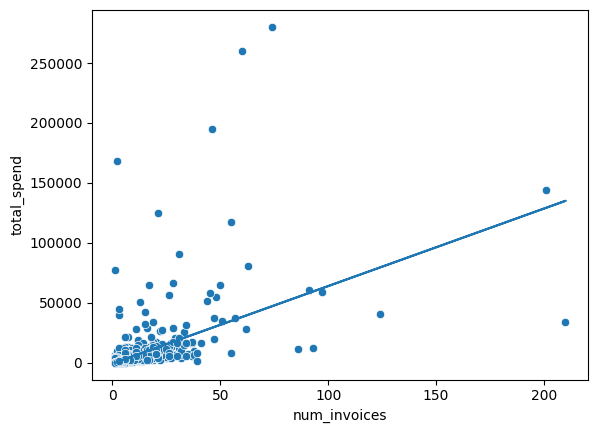

In [10]:

# ===============================================================
# 7. FR5 & FR6: LINEAR REGRESSION
# ===============================================================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# SIMPLE: total_spend ~ num_invoices
lr = LinearRegression()
lr.fit(customer_data[["num_invoices"]], customer_data["total_spend"])
pred = lr.predict(customer_data[["num_invoices"]])
print("\n=== FR5: Simple Regression R² =", r2_score(customer_data["total_spend"], pred))

plt.figure()
sns.scatterplot(x="num_invoices", y="total_spend", data=customer_data)
plt.plot(customer_data["num_invoices"], pred)
plt.savefig("outputs/regression_plots/simple_lr.png")

# MULTIPLE: total_spend ~ predictors
feat = ["num_invoices","total_quantity","avg_unit_price"]
mlr = LinearRegression()
mlr.fit(customer_data[feat], customer_data["total_spend"])
mlr_pred = mlr.predict(customer_data[feat])
print("=== FR6: Multiple Regression R² =", r2_score(customer_data["total_spend"], mlr_pred))



=== FR7: Logistic Regression ===
Accuracy: 1.0
F1: 1.0


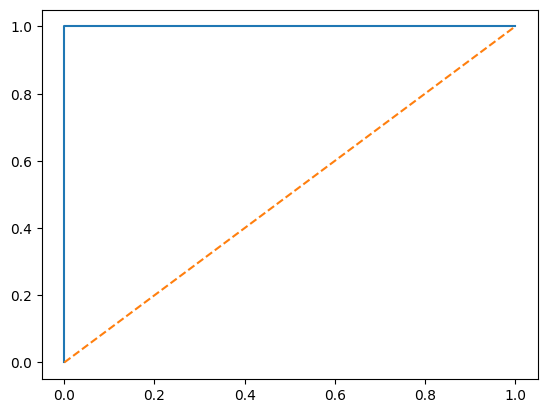

In [11]:

# ===============================================================
# 8. FR7: LOGISTIC REGRESSION
# ===============================================================
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

clf_log = Pipeline([("pre", transformer), ("log", LogisticRegression(max_iter=2000))])
clf_log.fit(X_train, y_train)

y_p = clf_log.predict(X_test)
y_prob = clf_log.predict_proba(X_test)[:,1]

print("\n=== FR7: Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test,y_p))
print("F1:", f1_score(y_test,y_p))

fpr,tpr,_ = roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--')
plt.savefig("outputs/classification_plots/logistic_roc.png")




=== FR8 KNN Best: {'knn__n_neighbors': 9}


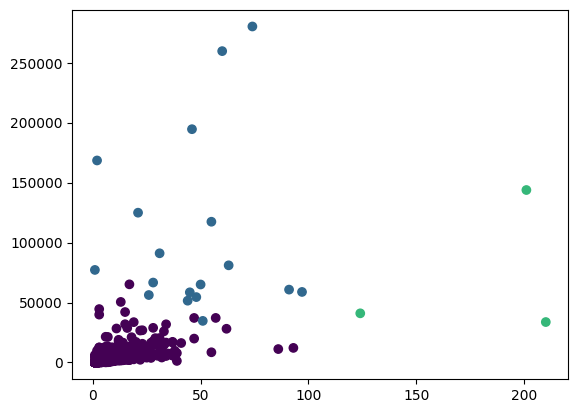

In [12]:

# ===============================================================
# 9. FR8: KNN & K-MEANS
# ===============================================================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_pipe = Pipeline([("pre", transformer), ("knn", KNeighborsClassifier())])
grid = GridSearchCV(knn_pipe, {"knn__n_neighbors":[3,5,7,9]},scoring="accuracy",cv=5)
grid.fit(X_train,y_train)
print("\n=== FR8 KNN Best:", grid.best_params_)

# K-MEANS
from sklearn.cluster import KMeans
sc = StandardScaler()
seg = sc.fit_transform(customer_data[["num_invoices","total_quantity","total_spend","avg_unit_price"]])

km = KMeans(n_clusters=4, random_state=42).fit(seg)
customer_data["cluster"] = km.labels_
plt.figure(); plt.scatter(customer_data["num_invoices"],customer_data["total_spend"],c=km.labels_)
plt.savefig("outputs/clustering_plots/kmeans.png")



In [13]:

# ===============================================================
# 10. FR9: MODEL COMPARISON & SAVE METRICS
# ===============================================================
print("\n=== FR9 MODEL COMPARISON ===")
from sklearn.model_selection import KFold, cross_val_score

models = {
    "Logistic": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(n_neighbors=grid.best_params_["knn__n_neighbors"])
}

scores = {}
for name, model in models.items():
    pipe = Pipeline([("pre", transformer), ("m", model)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores[name] = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy").mean()

metrics = pd.DataFrame([scores]).T
metrics.columns = ["CV_Accuracy"]
metrics.to_csv("outputs/metrics/final_models.csv")

print(metrics)
print("\n Project Completed Successfully!")


=== FR9 MODEL COMPARISON ===
          CV_Accuracy
Logistic     0.999309
KNN          0.985248

 Project Completed Successfully!
